# HELSINKI ENERGY CONSUMPTION 2020 RESEARCH

There is no collected database yet, however there is the open API here https://helsinki-openapi.nuuka.cloud/swagger/index.html

- list of properties: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List
- api request example: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Daily/ListByProperty?Record=LocationName&SearchString=1000%20Hakaniemen%20kauppahalli&ReportingGroup=Electricity&StartTime=2019-01-01&EndTime=2019-12-31

## Before going further - estimation of rows and dataset size
**max rows getting with 1 request is 10,000.**
- So, estimation, is it possible to get the 1 year hourly data of 1 place by 1 query:
- 366 days * 24 hours = 8,784 hours (rows); 8,800 < 10,000 it's okay
---
- Estimation of max rows for hourly data per year with all places:
- 842 places * 8,784 hours = 7,396,128 rows
- rough size approximation: 7,400,000 rows * 80 symbols =~ 600M it looks okay


---
# EXTRACTION OF DATA
---

In [1]:
import datetime
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt

In [94]:
class DownloadDataEnergyHelsinki:
    '''List of parameters available:
        date_begin & date_end format: 'yyyy-mm-dd'
        period format: 'Hourly' or 'Daily' or 'Monthly'
        '''
    
    def __init__(self, date_begin='2019-01-01', date_end='2019-12-31', period='Daily', location_list=[]):
        self.date_begin = date_begin
        self.date_end = date_end
        self.period = period
        self.location_list = location_list
        self.errors={}
    
    def __str__(self):
        return 'Date begin: {}\nDate end: {}\nPeriod: {}\nList of locations is {}\nDict of errors is {}'.format(
                self.date_begin, self.date_end, self.period, 
                'full' if self.location_list else 'empty',
                'full' if self.errors else 'empty'
                )
        
    def get_property_list_from_website(self, save_csv=False):
        '''Get list of locations from the website and optionally save it to property_list.csv'''
        
        r = requests.get('https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List')
        if r.status_code == 200:
            property_df = pd.DataFrame.from_dict(r.json())
            self.location_list = property_df[property_df['propertyName'].isna() == False]['locationName'].apply(lambda x: x.strip().replace(' ', '%20')).to_list()           
            print('Getting property list: success')
            if save_csv:
                property_df.to_csv('property_list.csv')
                print('Save property dataset to property_list.csv: success')
        else:
            print('Getting location list: failed')
    
    def get_property_list_from_csv(self, file_name='property_list.csv'):
        '''Get list of locations from the csv file (if previously saved)'''
        
        property_df = pd.read_csv(file_name)
        self.location_list = property_df[property_df['propertyName'].isna() == False]['locationName'].apply(lambda x: x.strip().replace(' ', '%20')).to_list()           
        print('Getting property list: success')
        
    def get_data_and_save_csv(self, custom_file_name='', num_of_loc=0, rewrite=True, from_error=False):
        '''Get available energy consumprion data for certain number of locations (all locations by default)
        rewrite: True - rewrite, False - add to existed
        from_error: True - switch list of locations to the error list and turn rewrite False'''
        
        if not self.location_list:
            print("File haven't been written: check list of locations (try get_location_list())")
            return
            
        num_of_loc = len(self.location_list) if num_of_loc == 0 else num_of_loc
        file_name = self.date_begin + ' ' + self.date_end + ' ' + self.period + '.csv' if custom_file_name == '' else custom_file_name + '.csv'
        
        errors = {}
        row_counter = 0
        
        if from_error:
            rewrite = False
            location_list = list(self.errors.keys())
            num_of_loc = len(location_list)
        else:
            location_list = self.location_list
        
        if rewrite:
            pd.DataFrame(columns=['timestamp', 'locationName', 'value', 'unit']).to_csv(file_name, index=False)
        
        print('Processing of {} places:'.format(num_of_loc))
        
        for i in range(num_of_loc):
            site = f'https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/{self.period}/ListByProperty?Record=LocationName&SearchString={location_list[i]}&ReportingGroup=Electricity&StartTime={self.date_begin}&EndTime={self.date_end}'
            try:
                r = requests.get(site)
                if len(r.json()) == 2:
                    errors[property_list[i]] = r.json()['errorNote']
                    print('.', end='')
                else:
                    sample = pd.DataFrame.from_dict(r.json())[['timestamp', 'locationName', 'value', 'unit']]
                    sample.to_csv(file_name, mode='a', header=False, index=False)
                    row_counter += len(r.json())
                    print('*', end='')
                    
            except:
                print('?', end='')
                errors[property_list[i]] = 'Unknown'
                
            print(end='' if (i+1)%10 else '|')
            print(end='' if (i+1)%100 else '\n')
    
        print('Done, {} rows has been written\n{} properties are missing'.format(row_counter, len(errors)))
        
        self.errors = errors
        errors_ls = [{'property':key, 'error':errors[key]} for key in errors.keys()]
        pd.DataFrame.from_dict(errors_ls).to_csv('Errors ' + file_name, index=False)
        
    def retry_errors(self):
        '''retry to get data from the error list and add it to the file'''
        
        self.get_data_and_save_csv(from_error=True)
        

In [95]:
downloader = DownloadDataEnergyHelsinki(date_begin="2020-01-01", date_end="2020-12-31", period='Hourly')
print(downloader)

Date begin: 2020-01-01
Date end: 2020-12-31
Period: Hourly
List of locations is empty
Dict of errors is empty


In [96]:
downloader.get_property_list_from_website()

Getting property list: success


In [97]:
downloader.get_data_and_save_csv()

Processing of 842 places:
**********|**********|****.*****|**********|***.******|.*********|****.**.**|.****.****|**********|**********|
******.***|**********|**********|*********.|**********|**.*******|**********|**********|**********|**********|
**********|*****.****|**********|******.***|**********|**********|**********|**********|**********|**********|
**********|*******.**|**********|**********|**********|**********|*****.****|**********|***.******|**********|
********.*|**********|.**.******|**********|**********|**********|*********.|*.********|*****.****|*******.**|
**.*******|*******..*|*********.|*****.****|.*********|***.*****.|**********|**********|******...*|**********|
*******.*.|***....**.|.*........|..........|..........|..........|..........|..........|..........|..........|
..........|..........|..........|..........|..........|..........|.........*|..........|..........|..........|
..........|........*.|..........|..........|..Done, 5101588 rows has been written
253 

---
# RESEARCHING
---

In [2]:
df = pd.read_csv('2020-01-01 2020-12-31 Hourly.csv')
df.head()

,timestamp,locationName,value,unit
0,2020-01-01T00:00:00,1000 Hakaniemen kauppahalli,0.06,kWh
1,2020-01-01T01:00:00,1000 Hakaniemen kauppahalli,0.06,kWh
2,2020-01-01T02:00:00,1000 Hakaniemen kauppahalli,0.06,kWh
3,2020-01-01T03:00:00,1000 Hakaniemen kauppahalli,0.07,kWh
4,2020-01-01T04:00:00,1000 Hakaniemen kauppahalli,0.06,kWh


In [3]:
# To work with months, weekdays and hours simplier

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
df['hour'] = df['timestamp'].apply(lambda x: x.hour)

In [5]:
df['week_day'] = df['timestamp'].dt.dayofweek

In [6]:
df['month'] = df['timestamp'].dt.month

In [7]:
df.head()

,timestamp,locationName,value,unit,hour,week_day,month
0,2020-01-01 00:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,0,2,1
1,2020-01-01 01:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,1,2,1
2,2020-01-01 02:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,2,2,1
3,2020-01-01 03:00:00,1000 Hakaniemen kauppahalli,0.07,kWh,3,2,1
4,2020-01-01 04:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,4,2,1


In [116]:
df['value'].describe().round(2)

count    4878780.00
mean          37.18
std           82.03
min            0.00
25%            5.34
50%           14.45
75%           35.84
max         2055.35
Name: value, dtype: float64

---
- Quite big range of values, let's look at distribution
---

<Axes: ylabel='Frequency'>

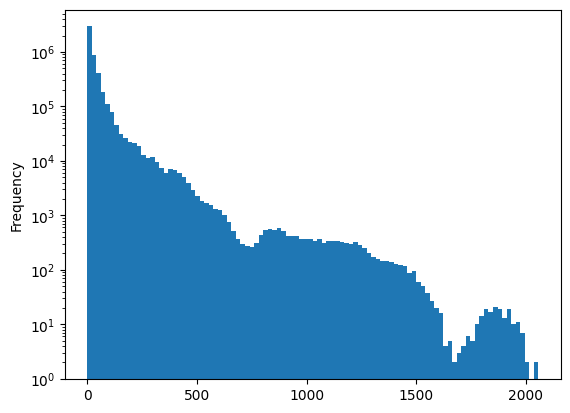

In [119]:
df['value'].plot.hist(bins=100, log=True)

In [9]:
df.isna().sum()

timestamp       0
locationName    0
value           0
unit            0
hour            0
week_day        0
month           0
dtype: int64

In [10]:
df.corr(numeric_only=True)

,value,hour,week_day,month
value,1.000000,0.007510,-0.039831,-0.003232
hour,0.007510,1.000000,0.000262,-0.000717
week_day,-0.039831,0.000262,1.000000,-0.006567
month,-0.003232,-0.000717,-0.006567,1.000000


In [8]:
df['locationName'].value_counts()

4661 Kalasataman TeHyKe                             78442
3505 Meritalo/Lpk Haukka/lp Haukka                  51250
1000 Hakaniemen kauppahalli                          8760
4186 Lpk Pentinkulma, Lp Linnunrata                  8760
4123 Lpk Oulunkylä                                   8760
                                                    ...  
4316 Vesalan ala-aste (disabled)                     1248
4514 Lpk Savotta                                      985
4144 Lpk Kukkaniitty (disabled)                       816
6475 Toinen linja 7, toimistorakennus (disabled)      672
4445 Lpk Kotitorppa (disabloitu)                      168
Name: locationName, Length: 582, dtype: int64

___
### For my purpose I would drop all the locations with partical or overwhelmed data. 24*365=8760

---

In [9]:
df_by_locations = df['locationName'].value_counts()
df_by_locations[df_by_locations.between(8750, 8760)]

1000 Hakaniemen kauppahalli                 8760
4186 Lpk Pentinkulma, Lp Linnunrata         8760
4123 Lpk Oulunkylä                          8760
4125 Vartiokylän ala-aste/Lpk Vartiokylä    8760
4126 Staffansby lågstadie/Lpk Staffan       8760
                                            ... 
4465 Laakso väestönsuoja                    8758
4146 Stadin am.op/Kullervonkatu 11          8758
4145 Botby grundskola                       8758
4142 Laajasalon peruskoulu/yläaste          8758
4273 Stadin am.op/Prinsessantie 2           8758
Name: locationName, Length: 557, dtype: int64

**557 out of 582 is quite enough**

In [10]:
list_of_locations = list(df_by_locations[df_by_locations.between(8750, 8760)].to_dict().keys())

In [11]:
df = df[df['locationName'].isin(list_of_locations)]

In [12]:
df

,timestamp,locationName,value,unit,hour,week_day,month
0,2020-01-01 00:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,0,2,1
1,2020-01-01 01:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,1,2,1
2,2020-01-01 02:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,2,2,1
3,2020-01-01 03:00:00,1000 Hakaniemen kauppahalli,0.07,kWh,3,2,1
4,2020-01-01 04:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,4,2,1
...,...,...,...,...,...,...,...
5092917,2020-12-30 20:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,648.96,kWh,20,2,12
5092918,2020-12-30 21:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,581.64,kWh,21,2,12
5092919,2020-12-30 22:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,503.15,kWh,22,2,12
5092920,2020-12-30 23:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,454.80,kWh,23,2,12


<Axes: xlabel='month'>

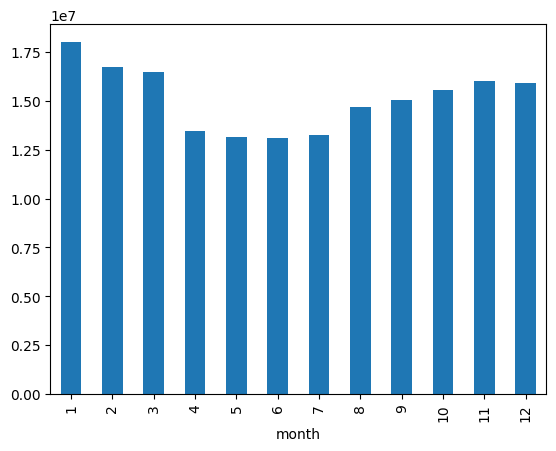

In [13]:
# Distribution sum kW by month

df.groupby('month')['value'].sum().plot.bar()

<Axes: xlabel='week_day'>

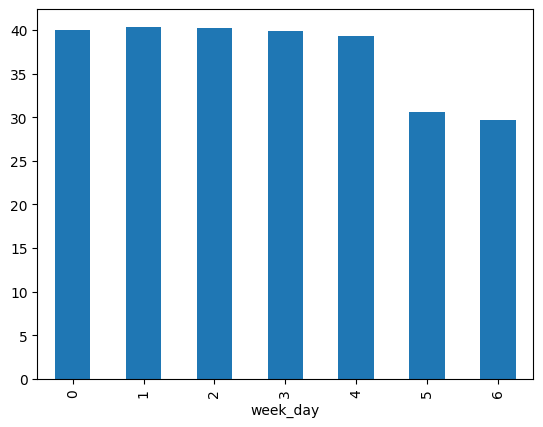

In [14]:
# Distribution mean kW by week day

df.groupby('week_day')['value'].mean().plot.bar()

<Axes: xlabel='hour'>

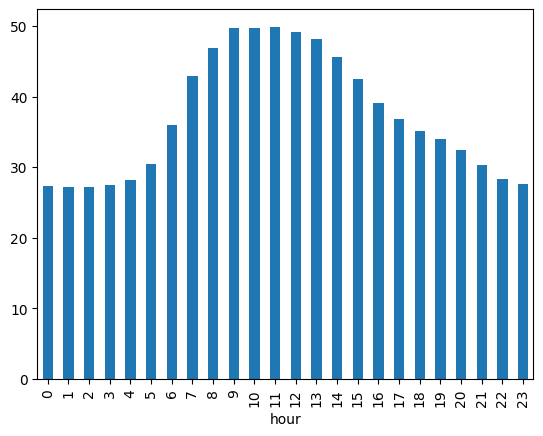

In [120]:
# Distribution mean kW by hour

df.groupby('hour')['value'].mean().plot.bar()

In [121]:
# mean kW by hour by location (top 20)

df.groupby('locationName')['value'].mean().sort_values(ascending=False).head(20)

locationName
2247 Tukkutori                                           1033.109379
4328 HYKS Psykiatriakeskus                                546.232359
2252 K 6 makasiini (disabled)                             491.583018
4370 Malmin päivystyssairaala, Malmin nuorisotalo         485.654960
4192 Laakson sairaala                                     455.811061
4229 Auroran sairaala ja koulu                            355.056970
4160 Koskelan monipuolinen palvelukeskus                  346.096416
4240 Kustaankartano                                       332.603722
1862 Kallion virastotalo                                  323.211885
3504 Helsingin Tennispalatsi Koy                          270.130099
4273 Stadin am.op/Prinsessantie 2                         262.600897
1761 K30, Leijonakortteli                                 257.834616
4003 Keskuspelastusasema                                  241.365421
1764 K31, Sarvikuono kortteli                             239.883697
4238 Itäkeskuksen uim

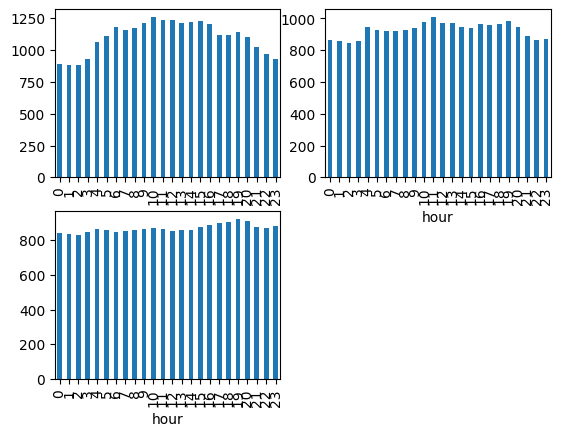

In [21]:
# look at some market in different week days (Th, Sa, Su):

plt.subplot(221)
df[(df['locationName'] == '2247 Tukkutori') & (df['week_day'] ==3)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(222)
df[(df['locationName'] == '2247 Tukkutori') & (df['week_day'] == 5)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(223)
df[(df['locationName'] == '2247 Tukkutori') & (df['week_day'] == 6)].groupby('hour')['value'].mean().plot.bar()

plt.show()

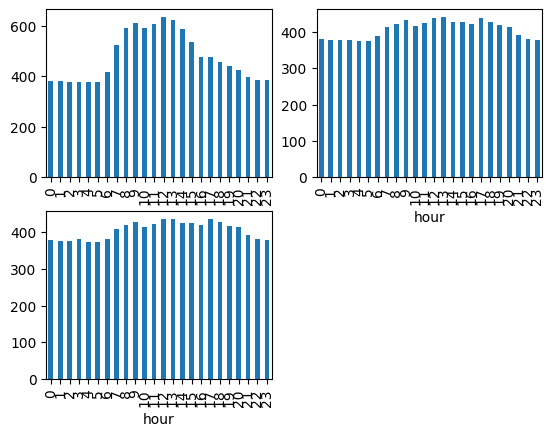

In [22]:
# look at some hospital in different week days (Th, Sa, Su):

plt.subplot(221)
df[(df['locationName'] == '4192 Laakson sairaala') & (df['week_day'] ==3)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(222)
df[(df['locationName'] == '4192 Laakson sairaala') & (df['week_day'] == 5)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(223)
df[(df['locationName'] == '4192 Laakson sairaala') & (df['week_day'] == 6)].groupby('hour')['value'].mean().plot.bar()

plt.show()

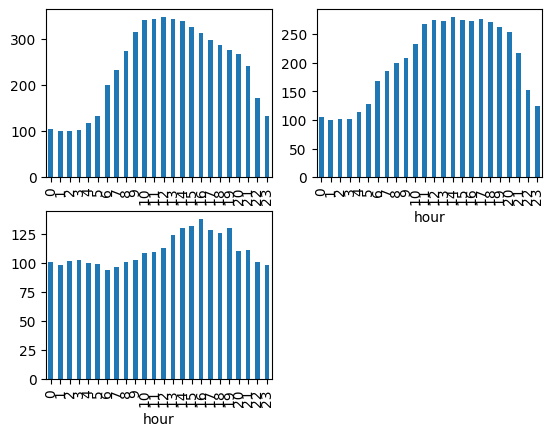

In [23]:
# look at some theater in different week days (Th, Sa, Su):

plt.subplot(221)
df[(df['locationName'] == '4479 Kaupunginteatteri') & (df['week_day'] ==3)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(222)
df[(df['locationName'] == '4479 Kaupunginteatteri') & (df['week_day'] == 5)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(223)
df[(df['locationName'] == '4479 Kaupunginteatteri') & (df['week_day'] == 6)].groupby('hour')['value'].mean().plot.bar()

plt.show()

---
I could classify the places which is working at holidays and which is not by comparison of max and min in Sunday

---

<Axes: ylabel='Frequency'>

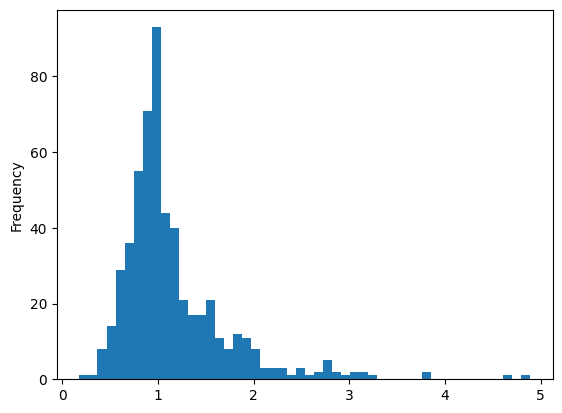

In [124]:
# Distribution of Sunday ratio (between 12 and 01 o'clock)

df_sunday_12 = df[(df['week_day'] == 6) & (df['hour'] == 13)].groupby('locationName')['value'].mean()
df_sunday_1 = df[(df['week_day'] == 6) & (df['hour'] == 1)].groupby('locationName')['value'].mean()
df_sunday_ratio = df_sunday_12 / df_sunday_1
df_sunday_ratio[df_sunday_ratio < 5].plot.hist(bins=50)

<Axes: ylabel='Frequency'>

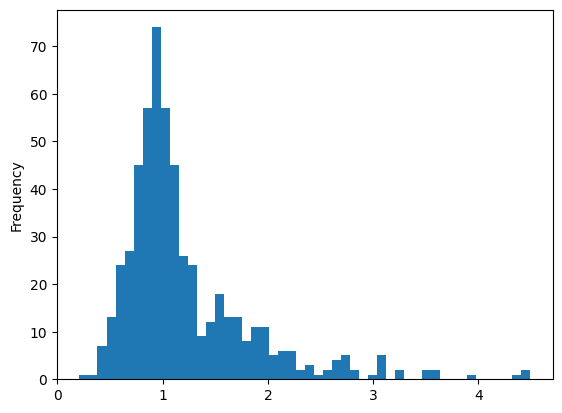

In [125]:
# Distribution of Saturday ratio (between 12 and 01 o'clock)

df_saturday_12 = df[(df['week_day'] == 5) & (df['hour'] == 13)].groupby('locationName')['value'].mean()
df_saturday_1 = df[(df['week_day'] == 5) & (df['hour'] == 1)].groupby('locationName')['value'].mean()
df_saturday_ratio = df_sunday_12 / df_sunday_1
df_saturday_ratio[df_saturday_ratio < 5].plot.hist(bins=50)

<Axes: ylabel='Frequency'>

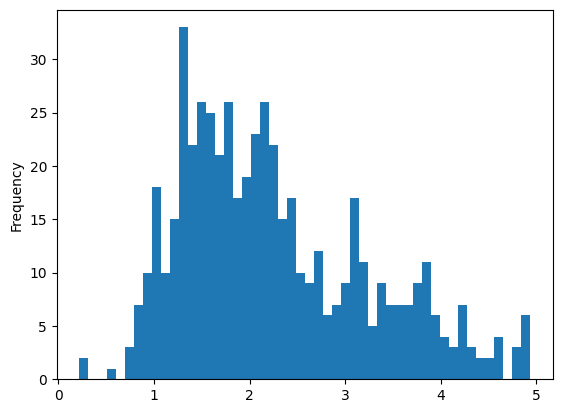

In [129]:
# Distribution of Wednesday ratio (between 12 and 01 o'clock)

df_wed_12 = df[(df['week_day'] == 2) & (df['hour'] == 13)].groupby('locationName')['value'].mean()
df_wed_1 = df[(df['week_day'] == 2) & (df['hour'] == 3)].groupby('locationName')['value'].mean()
df_wednesday_ratio = df_wed_12 / df_wed_1
df_wednesday_ratio[df_wednesday_ratio < 5].plot.hist(bins=50)

In [130]:
df_wednesday_ratio.describe()

count    553.000000
mean       2.554438
std        4.065778
min        0.219498
25%        1.511405
50%        2.094869
75%        3.064834
max       93.539216
Name: value, dtype: float64

---
- Majority of places doesn't work at holidays
- Typical ratios are in range 1.5-3
---

___
### 2) Dependance on air temperature 
---

In [13]:
# Processing Temperature Data. It has distinct datetime attributes and wrong UTC

df_tmp = pd.read_csv('temperature_helsinki_2020.csv')
df_tmp['datetime'] = pd.to_datetime(df_tmp['Year'].astype(str)+'-'+df_tmp['m'].astype(str)+'-'+df_tmp['d'].astype(str)+'-'+df_tmp['Time'].astype(str))

In [14]:
df_tmp.head()

,Year,m,d,Time,Time zone,Air temperature (degC),datetime
0,2019,12,31,00:00,UTC,4.1,2019-12-31 00:00:00
1,2019,12,31,01:00,UTC,3.8,2019-12-31 01:00:00
2,2019,12,31,02:00,UTC,3.4,2019-12-31 02:00:00
3,2019,12,31,03:00,UTC,3.3,2019-12-31 03:00:00
4,2019,12,31,04:00,UTC,3,2019-12-31 04:00:00


In [15]:
df_tmp['datetime'] = df_tmp['datetime'] + pd.DateOffset(hours=3)

In [16]:
df_tmp = df_tmp[['Air temperature (degC)', 'datetime']]

In [17]:
# Writing db to the file

df_tmp[df_tmp['datetime'].dt.year == 2020].to_csv('air_temp_helsinki_adapted.csv')

In [18]:
# Writing db to the DataFrame

df_tmp = df_tmp[df_tmp['datetime'].dt.year == 2020]

In [38]:
df_tmp = df_tmp.reset_index()

In [41]:
df_tmp['Air temperature (degC)'] = pd.to_numeric(df_tmp['Air temperature (degC)'], errors='coerce')

In [44]:
df_tmp.fillna(0)

,index,Air temperature (degC),datetime
0,21,-2.1,2020-01-01 00:00:00
1,22,-2.0,2020-01-01 01:00:00
2,23,-1.4,2020-01-01 02:00:00
3,24,-1.9,2020-01-01 03:00:00
4,25,-2.1,2020-01-01 04:00:00
...,...,...,...
8779,8800,0.8,2020-12-31 19:00:00
8780,8801,0.7,2020-12-31 20:00:00
8781,8802,0.5,2020-12-31 21:00:00
8782,8803,0.2,2020-12-31 22:00:00


---
### Now plotting:
---

In [45]:
means_by_hour = df.groupby('timestamp')['value'].mean().to_list()
temp_by_hour = df_tmp['Air temperature (degC)'].to_list()

In [48]:
df_means_temp = pd.DataFrame({'value':means_by_hour, 'temperature':temp_by_hour[:8760]})
df_means_temp.head()

,value,temperature
0,29.657038,-2.1
1,29.372711,-2.0
2,29.138995,-1.4
3,29.207935,-1.9
4,29.768330,-2.1


<Axes: xlabel='temperature', ylabel='value'>

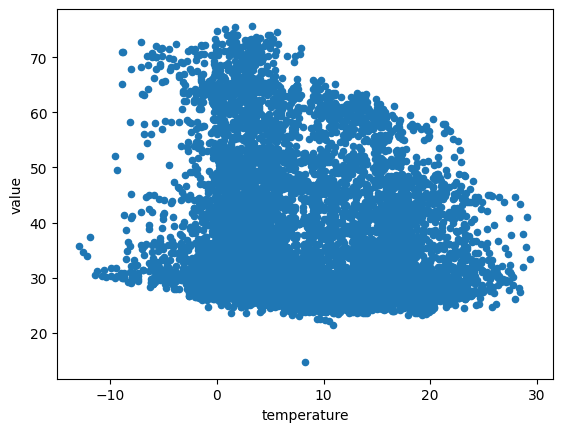

In [47]:
# mean values by temperature, all the values

df_means_temp.plot.scatter('temperature', 'value')

---
Too noisy, however it looks like it's a few trends, lowest and a few higher. I'll try to divide them

---

In [53]:
# # mean values by temperature, from 12 pm to 6 am (when everything is 100% closed)

means_by_hour_0_5 = df[df['timestamp'].dt.hour.between(0, 5)].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_0_5 = df_tmp[df_tmp['datetime'].dt.hour.between(0, 5)]['Air temperature (degC)'].to_list()

<Axes: xlabel='temperature', ylabel='value'>

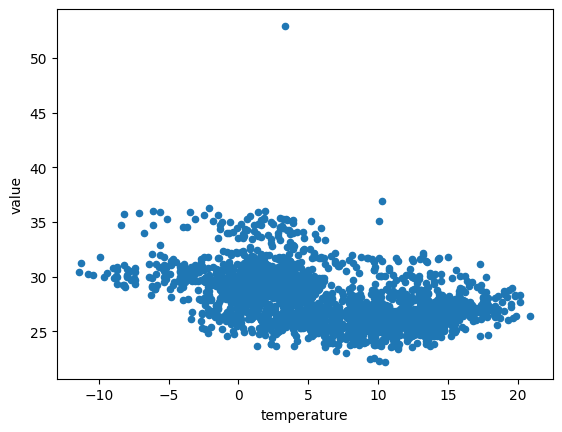

In [54]:
df_means_temp_0_5 = pd.DataFrame({'value':means_by_hour_0_5, 'temperature':temp_by_hour_0_5[:2190]})
df_means_temp_0_5.plot.scatter('temperature', 'value')

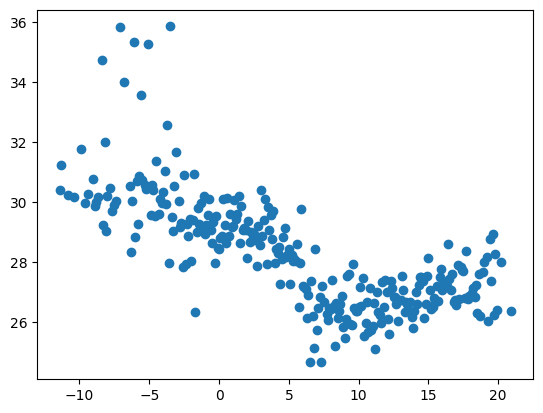

In [76]:
# The same, but for every temperature mean of mean values was calculated

plt.scatter(df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().values())

---
- It looks it has 2 trends and the most optimal point is around +10
---

In [103]:
# mean values by temperature, from 7 am to 7 pm Mo-Fr (typical business hours)

means_by_hour_7_18 = df[(df['timestamp'].dt.hour.between(7, 18) & (df['week_day'] <= 4))].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_7_18 = df_tmp[(df_tmp['datetime'].dt.hour.between(7, 18)) & (df_tmp['datetime'].dt.dayofweek <= 4)]['Air temperature (degC)'].to_list()

<Axes: xlabel='temperature', ylabel='value'>

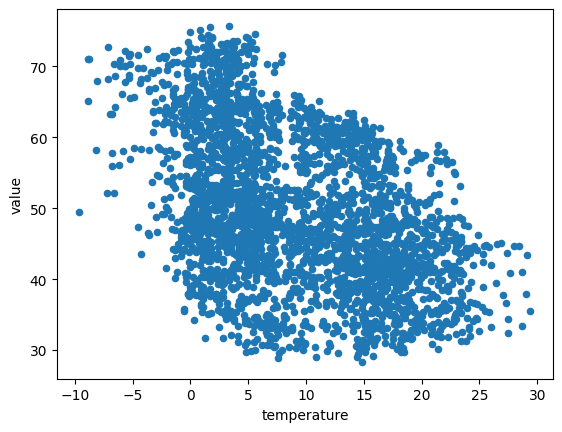

In [104]:
df_means_temp_7_18 = pd.DataFrame({'value':means_by_hour_7_18, 'temperature':temp_by_hour_7_18[:len(means_by_hour_7_18)]})
df_means_temp_7_18.plot.scatter('temperature', 'value')

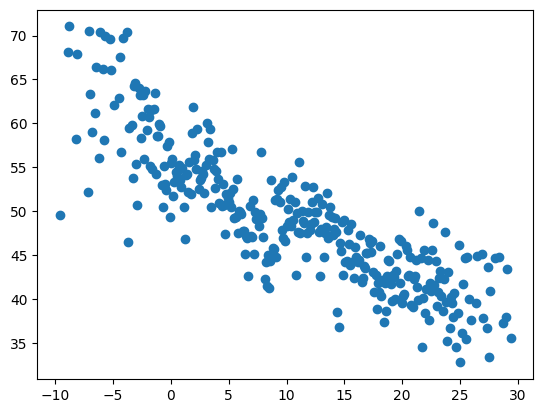

In [105]:
# The same, but for every temperature mean of mean values was calculated

plt.scatter(df_means_temp_7_18.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_7_18.groupby('temperature')['value'].mean().to_dict().values())

---
- looks like a linear trend down, approximately y = -5/7x + 56
---

#### doing the same with rounded temperature (to reduce noise)

In [106]:
# doing the same with rounded temperature (to reduce noise)

df_tmp['temp_rounded'] = df_tmp['Air temperature (degC)'].round(0)
df_tmp.head()

,index,Air temperature (degC),datetime,temp_rounded
0,21,-2.1,2020-01-01 00:00:00,-2.0
1,22,-2.0,2020-01-01 01:00:00,-2.0
2,23,-1.4,2020-01-01 02:00:00,-1.0
3,24,-1.9,2020-01-01 03:00:00,-2.0
4,25,-2.1,2020-01-01 04:00:00,-2.0


In [107]:
means_by_hour_0_5 = df[df['timestamp'].dt.hour.between(0, 5)].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_0_5 = df_tmp[df_tmp['datetime'].dt.hour.between(0, 5)]['temp_rounded'].to_list()

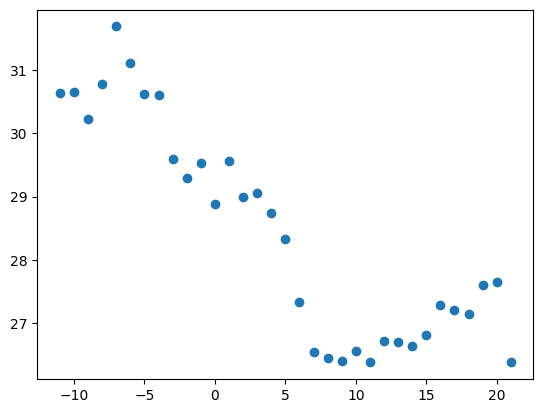

In [108]:
# mean of mean values by rounded temperature at night (0 - 6 am)

df_means_temp_0_5 = pd.DataFrame({'value':means_by_hour_0_5, 'temperature':temp_by_hour_0_5[:2190]})
plt.scatter(df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().values())

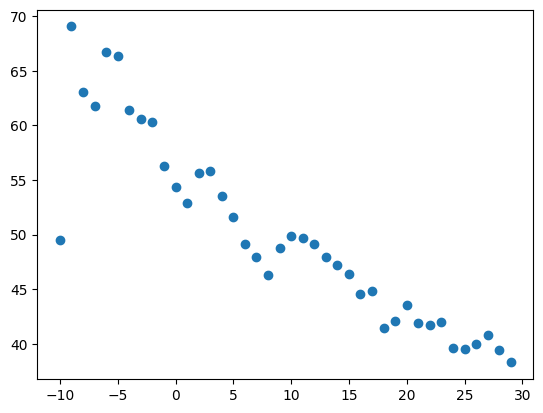

In [110]:
# mean of mean values by rounded temperature, from 7 am to 7 pm Mo-Fr (typical business hours)

means_by_hour_7_18 = df[(df['timestamp'].dt.hour.between(7, 18) & (df['week_day'] <= 4))].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_7_18 = df_tmp[(df_tmp['datetime'].dt.hour.between(7, 18)) & (df_tmp['datetime'].dt.dayofweek <= 4)]['temp_rounded'].to_list()

df_means_temp_7_18 = pd.DataFrame({'value':means_by_hour_7_18, 'temperature':temp_by_hour_7_18[:len(means_by_hour_7_18)]})

plt.scatter(df_means_temp_7_18.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_7_18.groupby('temperature')['value'].mean().to_dict().values())

## Observations:
It must be a relationship between air temperature and energy consumption:
- It's not a big range in time of idling (approx -1,5 kW mean for each +5C until +10C and then +1 kW for each +5C)
- It's a very big range while business hours and a clear linear dependence.